<h1 style="background-color:powderblue;">Seoul Bike Rental Prediction - AI-Pro - ITI </h1>


##### The Seoul Metropolitan Government launched a public bike-sharing service in 2015 called Seoul Bikes (“Ddareungi” in Korean). It was designed to be a self-operating rental service that could be used conveniently by anyone. Today in Seoul, there are over 150 rental stations centered in five areas of the city (Yeouido, Sangam, Sinchon, the 4 Great Gates area, and Seongsu). Currently there are 2,000 Seoul Bikes available to users, with plans to expand the project in the coming years. Seoul Bikes are a great way to travel distances that are a bit too far to walk, but a bit to close to bother with public transportation or a taxi. The bikes are eco-friendly, user friendly, and low-cost. Take a bike out for a spin and see a new side of Seoul.

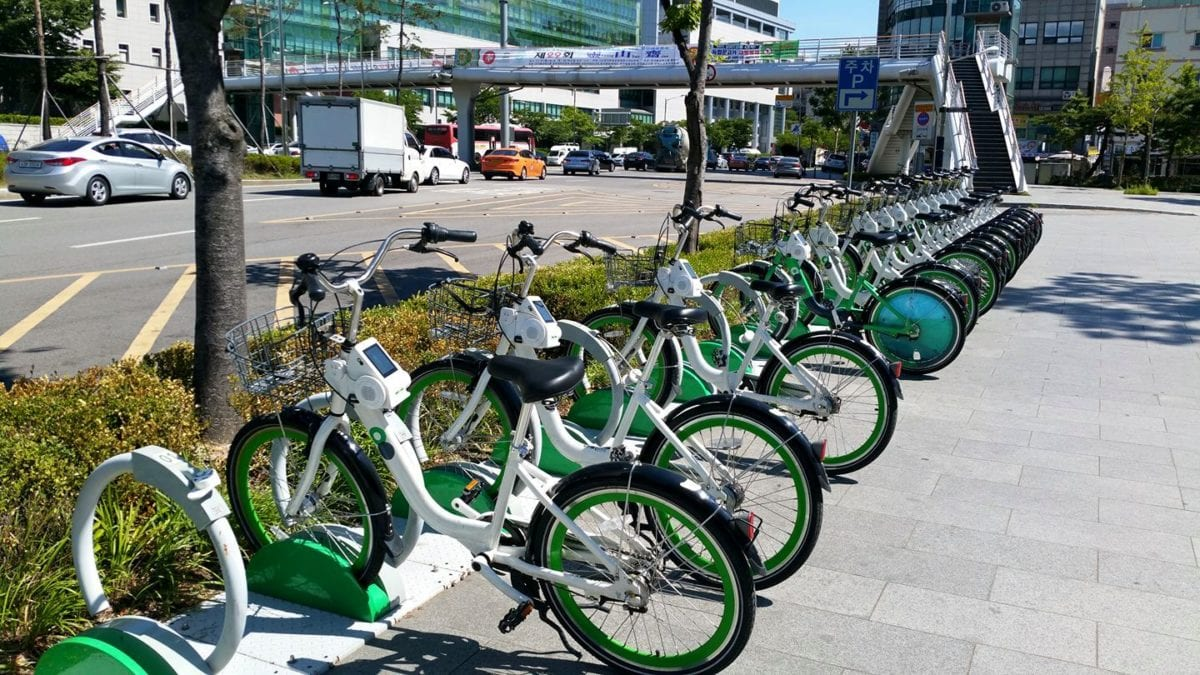

## Data fields

- `ID` - an ID for this instance
- `Date` - year-month-day
- `Hour` - Hour of he day
- `Temperature` - Temperature in Celsius
- `Humidity` - %
- `Windspeed` - m/s
- `Visibility` - 10m
- `Dew point temperature` - Celsius
- `Solar radiation` - MJ/m2
- `Rainfall` - mm
- `Snowfall` - cm
- `Seasons` - Winter, Spring, Summer, Autumn
- `Holiday` - Holiday/No holiday
- `Functional Day` - NoFunc(Non Functional Hours), Fun(Functional hours)
- `y` - Rented Bike count (Target), Count of bikes rented at each hour

# Team Members

In [ ]:
##################################################################################################################
#  Team Members :
#                 1-Abdullah Abdelhakeem
#                 2-Mohamed Sebaie
#                 3-Mohamed Mostafa
#                 4-Osama Ahmed
#                 5-Mahmoud Osama 
#
#  Version: v1.1.0 (Submitted)
#  Description: Seoul Bike Rental Prediction - AI-Pro - ITI
#  
#################################################################################################################

# Import Required Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#!pip install catboost
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize': [7, 7]}, font_scale=1.2)
%config Completer.use_jedi=False
pd.set_option("display.max_columns", None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read Train and Test Data

In [ ]:
dataset_path = '/kaggle/input/seoul-bike-rental-ai-pro-iti/'

dfTrainO = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
dfTestO = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
print("The shape of the dataset is {}.\n\n".format(dfTrainO.shape))
print("The shape of the dataset is {}.\n\n".format(dfTestO.shape))
dfTrainO.head()

__________________________________________________

# Preprocessing

In [ ]:
dictHoliday={"No Holiday":0,"Holiday":1}
dictFunction={"Yes":1,"No":0}
dictYears={2017:0,2018:1}

In [ ]:
def Preprocessing(df):
    df["Date"]            = pd.to_datetime(df["Date"], format='%d/%m/%Y')
    df["Year"]            = df['Date'].dt.year
    df["Month"]           = df['Date'].dt.month
    df["Day"]             = df["Date"].dt.day
    df["DayName"]         = df['Date'].dt.day_name()
    df["DayNumber"]       = df["Date"].dt.dayofweek
    df["WorkingDay"]      = df['Date'].dt.weekday.apply(lambda x: 0 if (x == 5) | (x == 6) else 1)
    df['WorkingDay']      = np.where((df['WorkingDay']==1 )& (df['Holiday']=="Holiday"), 0, df['WorkingDay'])
    df["Holiday"]         = df["Holiday"].map(dictHoliday)
    df["Functioning Day"] = df["Functioning Day"].map(dictFunction)
    df["Year"]            = df["Year"].map(dictYears)
    
    df.rename(columns={"Temperature(�C)": 'Temperature',"Dew point temperature(�C)": 'Dew_Point',
                             'Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_Speed','Visibility (10m)':'Visibility',
                             'Solar Radiation (MJ/m2)':'Solar_Radiation','Rainfall(mm)':'Rainfall',
                             'Snowfall (cm)':'Snowfall','Functioning Day':'Functioning_Day'},inplace=True)
    df['Temperature']=np.floor(df['Temperature']).astype(int)
    
    def extract_period_of_day1(hour):
        if hour in range(12):
            return 'Morning'
        elif hour in range(12, 18):
            return 'Afternoon'
        elif hour in range(18, 22):
            return 'Evening'
        else:
            return 'Night'
    def extract_period_of_day2(hour):
        if hour in range(6,19):
            return 1
        elif hour in range(19,24):
            return 0
        else:
            return 0
    def is_rush_hour(hour):
        return 1 if hour in [8,16, 17, 18, 19, 20, 21, 22] else 0
    def encode(data, col, max_val):
        data[col + '_Sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_Cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    df['Day_Period']   = df['Hour'].apply(extract_period_of_day1)
    df['Rush_Hour']    = df['Hour'].apply(is_rush_hour)
    df = encode(df,'Hour',23)
    df = encode(df,'DayNumber',6)
    df = encode(df,'Month',12)
    return df

### Train

In [ ]:
dfTrainNEW=Preprocessing(dfTrainO)
dfTrainNEW.head()

### Test

In [ ]:
dfTestNEW=Preprocessing(dfTestO)
dfTestNEW.head()

# Value Counts and Uniques Equations

In [ ]:
def ValueCounts(df):
    for c in df.columns:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].value_counts().to_frame())
        print("\n"+"******************"+"\n")
        
def UniqueValues(df,l):
    for c in l:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].unique())
        print("\n"+"******************"+"\n")

In [ ]:
ValueCounts(dfTrainNEW)

In [ ]:
ValueCounts(dfTestNEW)

In [ ]:
UniqueValues(dfTrainNEW,dfTrainNEW.columns)

In [ ]:
UniqueValues(dfTestNEW,dfTestNEW.columns)

In [ ]:
dfTrainNEW.describe().T

In [ ]:
dfTestNEW.describe().T

In [ ]:
dfTrainNEW.groupby('Hour')['y'].sum().plot(kind='bar');

In [ ]:
dfTrainNEW.groupby('Seasons')['y'].sum().plot(kind='bar');

_________________________________________________

_______________________________________________________

# Check for skewness

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(20,15)
figure.tight_layout()
sns.kdeplot(dfTrainNEW['Temperature']    ,shade=True, ax=axes[0][0]);
sns.kdeplot(dfTrainNEW['y']              ,shade=True, ax=axes[0][1]);
sns.kdeplot(dfTrainNEW['Humidity']       ,shade=True, ax=axes[0][2]);
sns.kdeplot(dfTrainNEW['Wind_Speed']     ,shade=True, ax=axes[1][0]);
sns.kdeplot(dfTrainNEW['Visibility']     ,shade=True, ax=axes[1][1]);
sns.kdeplot(dfTrainNEW['Dew_Point']      ,shade=True, ax=axes[1][2]);
sns.kdeplot(dfTrainNEW['Solar_Radiation'],shade=True, ax=axes[2][0]);
sns.kdeplot(dfTrainNEW['Rainfall']       ,shade=True, ax=axes[2][1]);
sns.kdeplot(dfTrainNEW['Snowfall']       ,shade=True, ax=axes[2][2]);

## Features to Check: `y`, `Wind_Speed`,`Visibility`,`Solar_Radiation`,`Rainfall`,`Snowfall`

In [ ]:
def SkewnessCheck(df,feature):
    df['log'+feature]   =df[feature].apply(np.log1p)
    df['sqrt'+feature]  =df[feature].apply(np.sqrt)
    df['squar'+feature] =np.power(df[feature],2)
    figure, axes = plt.subplots(nrows=1, ncols=4)
    figure.set_size_inches(20,10)
    sns.kdeplot(df['y']              ,shade=True, ax=axes[0]);
    sns.kdeplot(df['log'+feature]    ,shade=True, ax=axes[1]);
    sns.kdeplot(df['sqrt'+feature]   ,shade=True, ax=axes[2]);
    sns.kdeplot(df['squar'+feature]  ,shade=True, ax=axes[3]);

### `y`

In [ ]:
SkewnessCheck(dfTrainNEW,'y')

### `Wind_Speed`

In [ ]:
SkewnessCheck(dfTrainNEW,'Wind_Speed')

### `Visibility`

In [ ]:
SkewnessCheck(dfTrainNEW,'Visibility')

### `Solar_Radiation`

In [ ]:
SkewnessCheck(dfTrainNEW,'Solar_Radiation')

### `Rainfall`

In [ ]:
SkewnessCheck(dfTrainNEW,'Rainfall')

### `Snowfall`

In [ ]:
SkewnessCheck(dfTrainNEW,'Snowfall')

### `SquareRoot` Y        ------> Best
### `Log` WindSpeed       ------> Best
### `Square` Visibility   ------> Best
### `SolarRadiation`?? Original or SquareRoot

## Do The Same To Test Data

In [ ]:
dfTestNEW['logWind_Speed']         =dfTestNEW['Wind_Speed'].apply(np.log1p)
dfTestNEW['sqrtWind_Speed']        =dfTestNEW['Wind_Speed'].apply(np.sqrt)
dfTestNEW['squarWind_Speed']       =np.power(dfTestNEW['Wind_Speed'],2)
dfTestNEW['logVisibility']         =dfTestNEW['Visibility'].apply(np.log1p)
dfTestNEW['sqrtVisibility']        =dfTestNEW['Visibility'].apply(np.sqrt)
dfTestNEW['squarVisibility']       =np.power(dfTestNEW['Visibility'],2)
dfTestNEW['logSolar_Radiation']    =dfTestNEW['Solar_Radiation'].apply(np.log1p)
dfTestNEW['sqrtSolar_Radiation']   =dfTestNEW['Solar_Radiation'].apply(np.sqrt)
dfTestNEW['squarSolar_Radiation']  =np.power(dfTestNEW['Solar_Radiation'],2)
dfTestNEW['logRainfall']           =dfTestNEW['Rainfall'].apply(np.log1p)
dfTestNEW['sqrtRainfall']          =dfTestNEW['Rainfall'].apply(np.sqrt)
dfTestNEW['squarRainfall']         =np.power(dfTestNEW['Rainfall'],2)
dfTestNEW['logSnowfall']           =dfTestNEW['Snowfall'].apply(np.log1p)
dfTestNEW['sqrtSnowfall']          =dfTestNEW['Snowfall'].apply(np.sqrt)
dfTestNEW['squarSnowfall']         =np.power(dfTestNEW['Snowfall'],2)

## Drop the Columns we Don't Need

In [ ]:
dfTrainNEW.columns

In [ ]:
dfTrainNEW.drop(columns=['logy','sqrty','squary','sqrtWind_Speed','squarWind_Speed','squarVisibility',
                         'sqrtVisibility', 'logVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation',
                         'squarSolar_Radiation','logRainfall', 'sqrtRainfall', 'squarRainfall', 'logSnowfall',
                         'sqrtSnowfall','squarSnowfall'],inplace=True)

In [ ]:
dfTrainNEW.info()

In [ ]:
dfTestNEW.drop(columns=['sqrtWind_Speed','squarWind_Speed','squarVisibility', 'sqrtVisibility',
                        'logVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation', 'squarSolar_Radiation',
                        'logRainfall', 'sqrtRainfall', 'squarRainfall', 'logSnowfall', 'sqrtSnowfall',
                        'squarSnowfall'],inplace=True)

In [ ]:
dfTestNEW.info()

________________________________________________

# Plots To Visualize the Data

## Case1

In [ ]:
FeatureList=['Seasons', 'Holiday', 'Functioning_Day', 'WorkingDay','DayName',
                 'Month','Year','Day_Period', 'Rush_Hour']
def BarPlot(df,FeatureList):
    fig = plt.figure(figsize=(20, 25))
    i=1
    for feature in FeatureList:
        axes = fig.add_subplot(3, 3, i)
        sns.barplot(data=df, x=feature, y='y', ax=axes)
        axes.set(xlabel=feature, ylabel='Count', title='Average bike rentals across '+feature)
        i+=1

BarPlot(dfTrainNEW,FeatureList)

## Case2

In [ ]:
sns.barplot(data=dfTrainNEW, x='Day', y='y')

## Case3

In [ ]:
f, axes = plt.subplots(5, 2, figsize=(20, 25))

sns.boxplot(data=dfTrainNEW, y='y', x='Seasons'        , ax=axes[0][0],hue='Holiday')
sns.boxplot(data=dfTrainNEW, y='y', x='Holiday'        , ax=axes[0][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Functioning_Day', ax=axes[1][0])
sns.boxplot(data=dfTrainNEW, y='y', x='WorkingDay'     , ax=axes[1][1])
sns.boxplot(data=dfTrainNEW, y='y', x='DayName'        , ax=axes[2][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Month'          , ax=axes[2][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Year'           , ax=axes[3][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day_Period'     , ax=axes[3][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Rush_Hour'      , ax=axes[4][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day'            , ax=axes[4][1])

plt.show()

## Case4

In [ ]:
dfTrainNEW_w = dfTrainNEW[dfTrainNEW["WorkingDay"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["WorkingDay"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round'] = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case5

In [ ]:
dfTrainNEW_R = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 1]
dfTrainNEW_nR = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 0]

bin_size = 4
dfTrainNEW_R['Temp Round'] = dfTrainNEW_R['Temperature']//bin_size
dfTrainNEW_nR['Temp Round'] = dfTrainNEW_nR['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_R.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nR.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Rush Hours: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Rush Hours: Average count given across temperature range')

plt.show()

## Case6

In [ ]:
dfTrainNEW_w  = dfTrainNEW[dfTrainNEW["Holiday"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["Holiday"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round']  = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w  = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig  = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case7

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='WorkingDay', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

## Case8

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='Rush_Hour', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Rush Hour', 'Rush Hour'])
axes.set(title='Hourly Count based on Rush Hour or not')

plt.show()

## Case9

In [ ]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(dfTrainNEW.groupby(['WorkingDay', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='Hour', y='y', hue='WorkingDay', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day if Working day or Not')

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(dfTrainNEW.groupby(['DayName', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='Hour', y='y', hue='DayName', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Weekdays')

plt.show()

## Case10

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(dfTrainNEW.groupby(['Month', 'WorkingDay'])['y'].mean()).reset_index()
sns.barplot(data=group_month, x='Month', y='y', hue='WorkingDay', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

# Correlations

In [ ]:
corr_matrix = dfTrainNEW.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(25, 20))
sns.heatmap(np.round(corr_matrix,2), mask=mask, annot=True, cbar=True, vmax=0.8, vmin=-0.8, cmap='RdYlGn')
plt.show()

In [ ]:
abs(dfTrainNEW.corr()["y"]).sort_values(ascending=False)

## Outliers Check

In [ ]:
def zscore(series): 
    return (series-series.mean())/series.std()
dfTrainNEW_O=dfTrainNEW.copy()
dfTrainNEW_O['count_zscore'] = dfTrainNEW.groupby(['Hour', 'WorkingDay'])['y'].transform(zscore)
outlier_idx = np.abs(dfTrainNEW_O['count_zscore'])>3
outlier_data = dfTrainNEW_O.loc[outlier_idx, :]
print('Shape of the outlier data entries: ', outlier_data.shape)
outlier_data

##### Removing Outliers from Data

In [ ]:
#Removing outliers from Data
dfTrainNEW_Wo = dfTrainNEW_O.loc[~outlier_idx, :]
print('Shape of Data Before Outlier Pruning: ', dfTrainNEW.shape)
print('Shape of Data After Outlier Pruning: ', dfTrainNEW_Wo.shape)

# Categorical Columns Encoding

## 1. One Hot Encoding

In [ ]:
def OneHotEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Dummies = df.copy()
        dfTrainEncoded_Dummies = pd.get_dummies(dfTrainEncoded_Dummies,columns=FeaturesL,drop_first=True)
        return dfTrainEncoded_Dummies
    elif Train_or_Test == 'Test':
        dfTestEncoded_Dummies  = df.copy()
        dfTestEncoded_Dummies  = pd.get_dummies(dfTestEncoded_Dummies, columns=FeaturesL,drop_first=True)
        return dfTestEncoded_Dummies

_______________________________

## 2. Label Encoding

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

def LabelEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Labels = df.copy()
        dfTrainEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTrainEncoded_Labels)
        return dfTrainEncoded_Labels
    elif Train_or_Test == 'Test':
        dfTestEncoded_Labels = df.copy()
        dfTestEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTestEncoded_Labels)
        return dfTestEncoded_Labels

________________

# Check the Correlation

## 1. One Hot Encoding

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW,FeaturesL,'Train')

In [ ]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values(ascending=False)

In [ ]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values().index

In [ ]:
dfTrainEncoded_Dummies.columns

## 2. Label Encoding

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW,FeaturesL,'Train')

In [ ]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values(ascending=False)

In [ ]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values().index

____________________________________________

# Machine Learning Model 

## Train Data

In [ ]:
FeaturesL=['DayName','Seasons','Day_Period']

In [ ]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Dummies =OneHotEncoding(dfTestNEW,  FeaturesL,'Test')

In [ ]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Labels =LabelEncoding(dfTestNEW,  FeaturesL,'Test')

In [ ]:
dfTrain = dfTrainEncoded_Labels.drop(columns = ['DayNumber','Hour','Year',"Date",'Dew_Point',
                                                'DayName','Seasons','Wind_Speed','Snowfall'])

In [ ]:
dfTest = dfTestEncoded_Labels.drop(columns = ['DayNumber','Hour','Year',"Date",'Dew_Point','DayName',
                                              'Seasons','Wind_Speed','Snowfall'])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(dfTrain, test_size=0.2, random_state=42,stratify =None)
X_train = train_df.drop(columns=["ID","y",'Day','Month'])
y_train = train_df['y']
################################################################################################
X_val = val_df.drop(columns=["ID","y",'Day','Month'])
y_val = val_df['y']

In [ ]:
y_trainLog=np.log1p(y_train)
y_valLog=np.log1p(y_val)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']] = scaler.fit_transform(X_train[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']].values)
X_val[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']] = scaler.transform(X_val[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']].values)

In [ ]:
#!pip install catboost

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [ ]:
def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    
    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [ ]:
models = {
    "LinearRegression":            LinearRegression(),
    "Ridge":                       Ridge(),
    "Lasso":                       Lasso(),
    "ElasticNet":                  ElasticNet(),
    "KNeighborsRegressor":         KNeighborsRegressor(), 
    "DecisionTreeRegressor":       DecisionTreeRegressor(),
    "RandomForestRegressor":       RandomForestRegressor(),
    "BaggingRegressor":            BaggingRegressor(),
    "AdaBoostRegressor":           AdaBoostRegressor(),
    "CatBoostRegressor":           CatBoostRegressor(verbose=False),
    "LGBMRegressor":               LGBMRegressor(),
    "GradientBoostingRegressor":   GradientBoostingRegressor(),
    "XGBRegressor":                XGBRegressor()
}

In [ ]:
for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(X_train, y_trainLog)
    print(f"train score : {model.score(X_train,y_trainLog)}")
    print(f'RMSLETrain: {rmsle(y_trainLog, model.predict(X_train))}')
    print(f'RMSLEVal: {rmsle(y_valLog, model.predict(X_val))}')
    print('-'*30)

_____________________________________________________________

## Test Data

In [ ]:
# Work With Test Data
ID=dfTest["ID"]
X_test = dfTest.drop(columns=['ID','Day','Month'])
X_test[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']]=scaler.transform(X_test[['Temperature','Humidity','Visibility','Solar_Radiation','Rainfall','logWind_Speed']])

# Train the Model
Model=CatBoostRegressor(verbose=False,loss_function="MAE", n_estimators=1872 ,
                        learning_rate=0.17368421052631577,depth=4,l2_leaf_reg=2,
                        random_strength=0.665,random_seed=0)
Model.fit(X_train, y_trainLog)

# Print RMSLE for Train and Validation
print(f'RMSLETrain: {rmsle(y_trainLog, Model.predict(X_train))}')
print(f'RMSLEVal: {rmsle(y_valLog, Model.predict(X_val))}')



# Print the Features Importance of Cat Boost
sorted_feature_importance = Model.feature_importances_.argsort()
plt.barh(dfTest.drop(columns=['ID']).columns[sorted_feature_importance], 
        Model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")
dfTest.drop(columns=['ID']).columns[sorted_feature_importance]

# Predict the Bikes Count for Test Data
y_test_predicted = Model.predict(X_test)
dfTest['y'] = np.floor(np.exp(y_test_predicted)).astype('int') 
dfTest['y'] = np.where(dfTest['Functioning_Day']==0, 0, dfTest['y'])
yPredictTest=dfTest['y']

# Submit the File
dfTest.drop(columns="ID",inplace=True)
dfTest=pd.concat([dfTest, ID],axis=1)

dfTest[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)
#dfTest[['ID', 'y']].to_csv('submission.csv', index=False)

________________________________________________________